# GMM Clustering for Temperature-based Sensor Data (Improved Version)

This notebook implements Gaussian Mixture Model (GMM) clustering with 3 components to identify hot, cold, and normal temperature states based on sensor readings.

## Background Context
Based on the capacitance/resistance-strain models from the papers:
- Sensor readings represent electrical properties (capacitance/resistance) of touch sensors
- Temperature affects sensor behavior and electrical characteristics
- Sensor readings are influenced more by other factors (pressure, touch type) than temperature alone
- We aim to cluster sensor readings into temperature categories using GMM

## Data Structure
- Temperature ranges: 20-30, 30-40, 40-50, 50-60, 60-70, 70-85 (°C) (ground truth labels)
- Features: sensor_1, sensor_2, sensor_3, sensor_4 (sensor readings)
- Each CSV file contains time-series sensor data

## Clustering Goal
- **3 Clusters**: Hot, Cold, Normal (must use exactly 3 clusters)
- Based on sensor reading patterns across different temperature conditions
- Use temperature labels to guide initialization for better alignment

## Key Improvements
1. **Enhanced Feature Engineering**: Added cross-sensor ratios, differences, and coefficient of variation
2. **Temperature-Guided Initialization**: Initialize GMM means from temperature category statistics
3. **Better Preprocessing**: Use StandardScaler to preserve temperature-related variance
4. **Improved Cluster Labeling**: Use majority vote from temperature categories for alignment


## Step 1: Import Required Libraries


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## Step 2: Load and Explore Data


In [40]:
# Define base path
base_path = Path('../temperatures_range')

# Temperature range folders
temp_ranges = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-85']

# Load all CSV files
data_list = []

print("Loading data from all temperature ranges...")
for temp_range in temp_ranges:
    temp_folder = base_path / temp_range
    if temp_folder.exists():
        csv_files = list(temp_folder.glob('*.csv'))
        print(f"\n{temp_range}°C: Found {len(csv_files)} files")
        
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Add temperature range as metadata
                df['temp_range'] = temp_range
                # Add file identifier
                df['file_id'] = csv_file.stem
                data_list.append(df)
            except Exception as e:
                print(f"  Error loading {csv_file.name}: {e}")

# Combine all data
combined_data = pd.concat(data_list, ignore_index=True)

print(f"\n{'='*60}")
print(f"Total rows loaded: {len(combined_data):,}")
print(f"Total columns: {len(combined_data.columns)}")
print(f"Temperature ranges: {combined_data['temp_range'].unique()}")
print(f"{'='*60}")


Loading data from all temperature ranges...

20-30°C: Found 10 files

30-40°C: Found 10 files

40-50°C: Found 10 files

50-60°C: Found 10 files

60-70°C: Found 10 files

70-85°C: Found 10 files

Total rows loaded: 99,417
Total columns: 9
Temperature ranges: ['20-30' '30-40' '40-50' '50-60' '60-70' '70-85']


In [41]:
# Display basic statistics
print("\nDataset Info:")
print(combined_data.info())

print("\n" + "="*60)
print("First few rows:")
print(combined_data.head(10))



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99417 entries, 0 to 99416
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   elapsed_time_s  99417 non-null  float64
 1   clock_time      99417 non-null  object 
 2   time_ms         99417 non-null  int64  
 3   sensor_1        99417 non-null  int64  
 4   sensor_2        99417 non-null  int64  
 5   sensor_3        99417 non-null  int64  
 6   sensor_4        99417 non-null  int64  
 7   temp_range      99417 non-null  object 
 8   file_id         99417 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 6.8+ MB
None

First few rows:
   elapsed_time_s clock_time  time_ms  sensor_1  sensor_2  sensor_3  sensor_4  \
0          10.012   12:57:24  4157171       180       477       540       481   
1          10.038   12:57:24  4157196       166       413       472       419   
2          10.061   12:57:24  4157220       148       3

In [42]:
# Extract sensor columns
sensor_columns = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']

print("\nSensor Statistics by Temperature Range:")
print("="*60)
for temp_range in sorted(combined_data['temp_range'].unique()):
    temp_data = combined_data[combined_data['temp_range'] == temp_range][sensor_columns]
    print(f"\n{temp_range}°C:")
    print(temp_data.describe())



Sensor Statistics by Temperature Range:

20-30°C:
           sensor_1      sensor_2      sensor_3      sensor_4
count  16567.000000  16567.000000  16567.000000  16567.000000
mean     130.010080    408.679845    672.112211    316.806422
std       43.931546     55.726872    177.592396    137.655345
min       40.000000    226.000000    425.000000     51.000000
25%       92.000000    364.000000    500.000000    179.000000
50%      115.000000    412.000000    691.000000    313.000000
75%      165.000000    446.000000    820.000000    449.000000
max      280.000000    682.000000   1124.000000    528.000000

30-40°C:
           sensor_1      sensor_2      sensor_3      sensor_4
count  16569.000000  16569.000000  16569.000000  16569.000000
mean     136.418492    409.817853    673.405577    317.003923
std       41.348391     53.570925    178.537825    134.914228
min       33.000000    201.000000    441.000000     50.000000
25%       98.000000    365.000000    501.000000    180.000000
50%      

## Step 3: Data Analysis and Exploration


In [43]:
# Check for missing values
print("Missing Values Check:")
print(combined_data[sensor_columns].isnull().sum())

# Check for outliers using IQR method
print("\nOutlier Detection (using IQR method):")
Q1 = combined_data[sensor_columns].quantile(0.25)
Q3 = combined_data[sensor_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((combined_data[sensor_columns] < lower_bound) | (combined_data[sensor_columns] > upper_bound)).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()} ({outliers.sum()/len(combined_data)*100:.2f}%)")


Missing Values Check:
sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
dtype: int64

Outlier Detection (using IQR method):
Number of outliers detected: 1243 (1.25%)


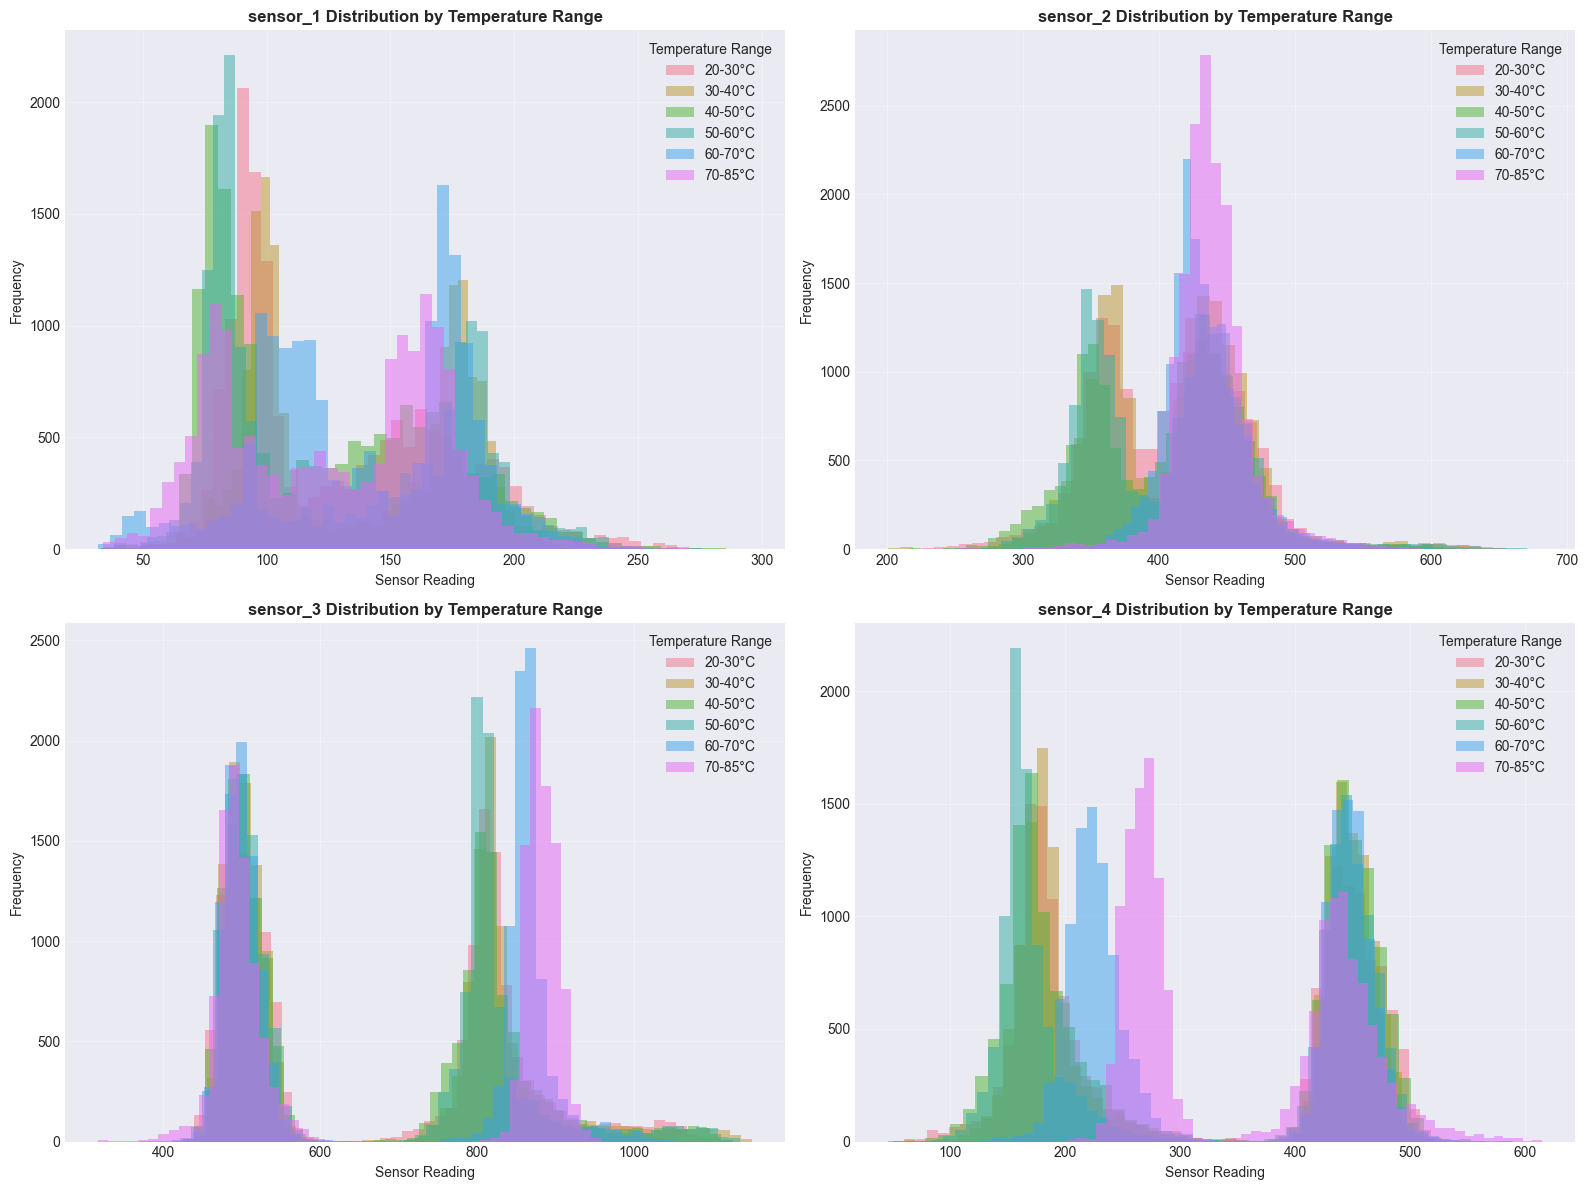

In [44]:
# Visualize sensor distributions by temperature range
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, sensor in enumerate(sensor_columns):
    for temp_range in sorted(combined_data['temp_range'].unique()):
        temp_data = combined_data[combined_data['temp_range'] == temp_range][sensor]
        axes[idx].hist(temp_data, alpha=0.5, label=f"{temp_range}°C", bins=50)
    
    axes[idx].set_title(f'{sensor} Distribution by Temperature Range', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sensor Reading', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend(title='Temperature Range')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temperature_sensor_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


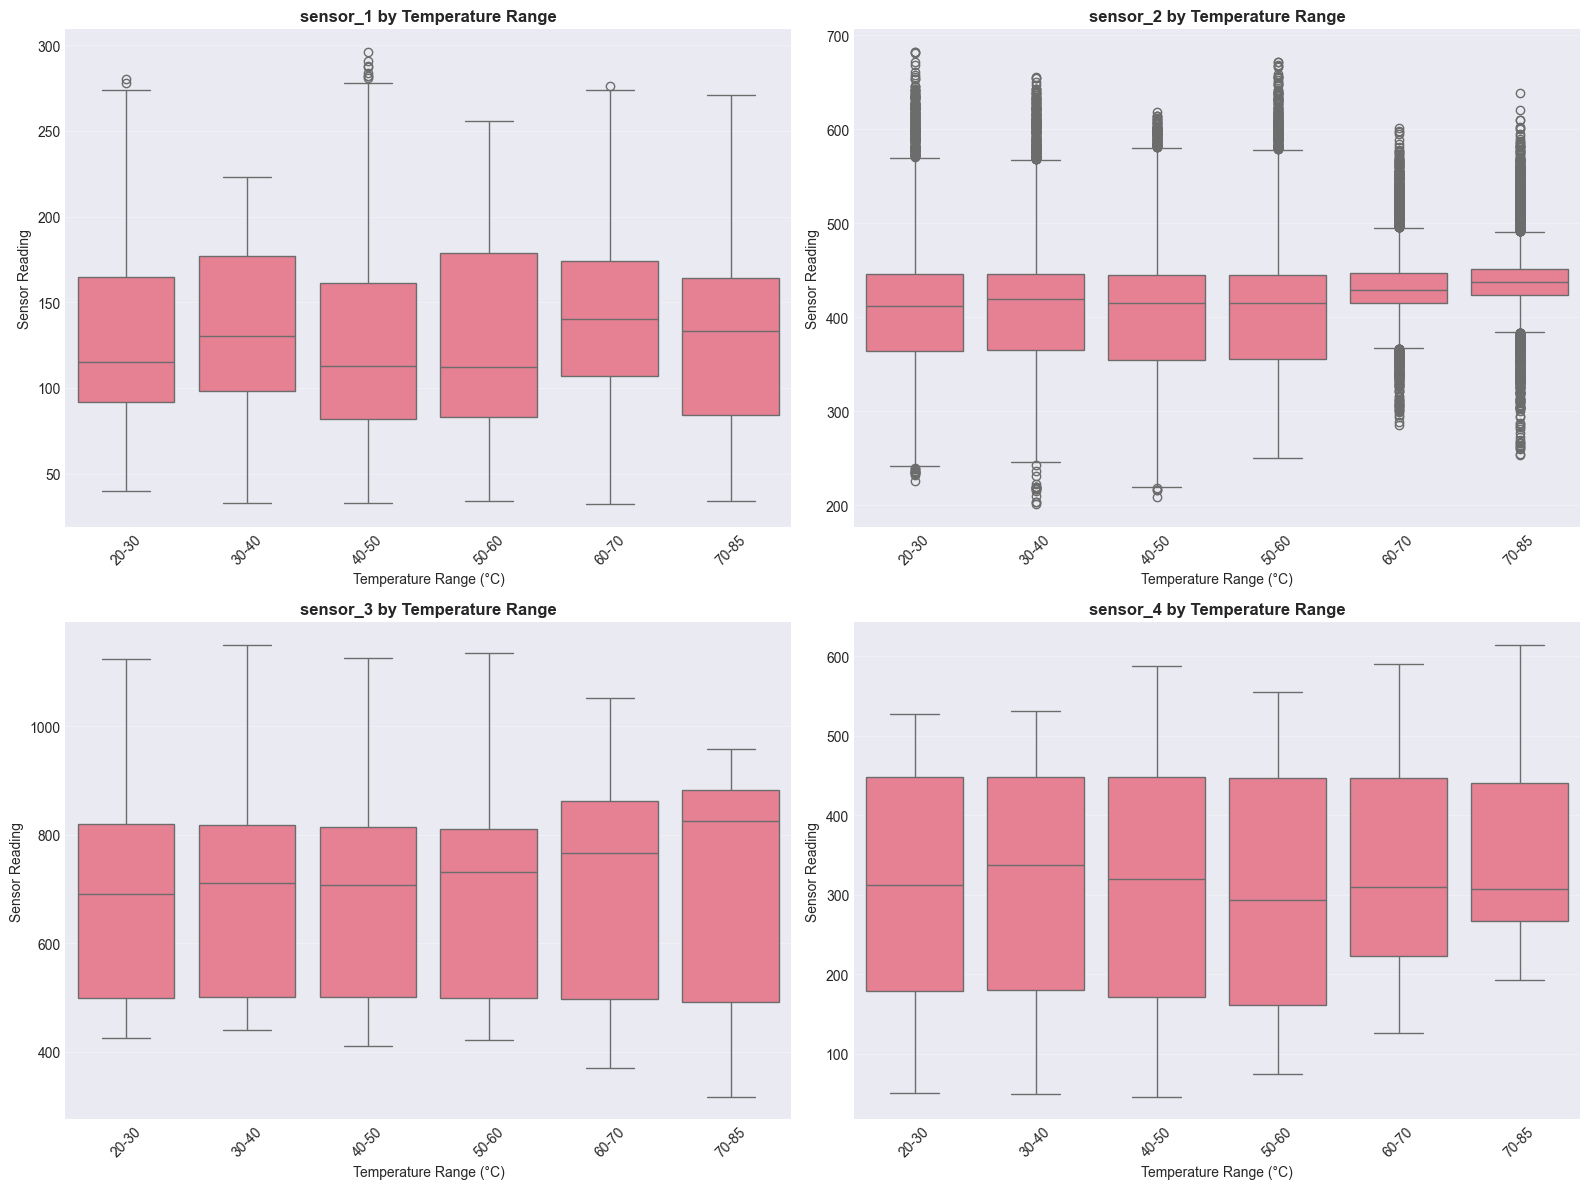

In [45]:
# Box plots for sensor readings by temperature
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, sensor in enumerate(sensor_columns):
    sns.boxplot(data=combined_data, x='temp_range', y=sensor, ax=axes[idx])
    axes[idx].set_title(f'{sensor} by Temperature Range', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Temperature Range (°C)', fontsize=10)
    axes[idx].set_ylabel('Sensor Reading', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('temperature_sensor_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()


Correlation Matrix for Sensor Readings:
          sensor_1  sensor_2  sensor_3  sensor_4
sensor_1  1.000000  0.558644 -0.799416  0.855225
sensor_2  0.558644  1.000000 -0.297357  0.669474
sensor_3 -0.799416 -0.297357  1.000000 -0.870742
sensor_4  0.855225  0.669474 -0.870742  1.000000


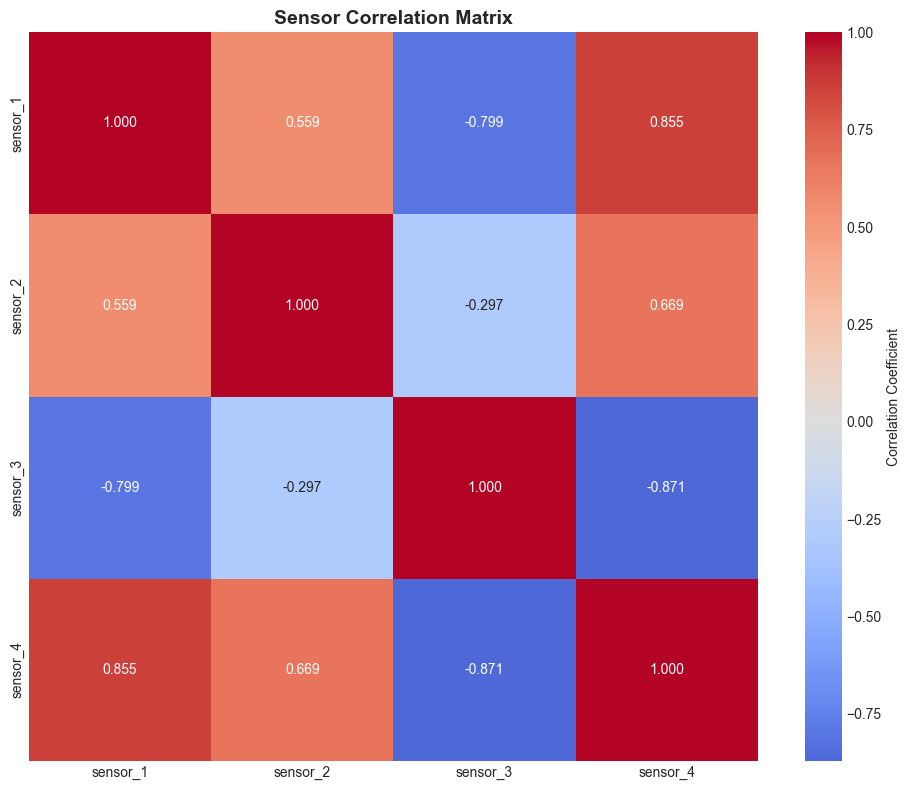

In [46]:
# Correlation analysis
print("Correlation Matrix for Sensor Readings:")
corr_matrix = combined_data[sensor_columns].corr()
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Sensor Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sensor_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 4: Feature Engineering and Preprocessing


In [47]:
# Extract sensor features
X_sensors = combined_data[sensor_columns].values

# Create temperature mapping for feature engineering
temp_mapping = {
    '20-30': 25,
    '30-40': 35,
    '40-50': 45,
    '50-60': 55,
    '60-70': 65,
    '70-85': 77.5
}
combined_data['temp_numeric'] = combined_data['temp_range'].map(temp_mapping)

# Feature engineering: Add statistical features
# Mean of all sensors
mean_sensor = X_sensors.mean(axis=1)
# Standard deviation of all sensors (variance in readings)
std_sensor = X_sensors.std(axis=1)
# Range (max - min) of sensors (sensor variability)
range_sensor = X_sensors.max(axis=1) - X_sensors.min(axis=1)
# Ratio features (sensor relationships)
ratio_12 = X_sensors[:, 0] / (X_sensors[:, 1] + 1e-8)  # Avoid division by zero
ratio_34 = X_sensors[:, 2] / (X_sensors[:, 3] + 1e-8)
# Cross-sensor ratios
ratio_13 = X_sensors[:, 0] / (X_sensors[:, 2] + 1e-8)
ratio_24 = X_sensors[:, 1] / (X_sensors[:, 3] + 1e-8)

# Additional features: Sensor differences (capture sensor interactions)
diff_12 = X_sensors[:, 1] - X_sensors[:, 0]  # sensor_2 - sensor_1
diff_34 = X_sensors[:, 3] - X_sensors[:, 2]  # sensor_4 - sensor_3

# Coefficient of variation (relative variability)
cv_sensor = std_sensor / (mean_sensor + 1e-8)

# Combine original features with engineered features
X_combined = np.column_stack([
    X_sensors,           # Original 4 sensor readings
    mean_sensor,         # Average sensor reading
    std_sensor,          # Sensor variability
    range_sensor,        # Sensor range
    ratio_12,            # Sensor ratio 1/2
    ratio_34,            # Sensor ratio 3/4
    ratio_13,            # Sensor ratio 1/3
    ratio_24,            # Sensor ratio 2/4
    diff_12,             # Sensor difference 2-1
    diff_34,             # Sensor difference 4-3
    cv_sensor            # Coefficient of variation
])

feature_names = sensor_columns + ['mean_sensor', 'std_sensor', 'range_sensor', 
                                  'ratio_12', 'ratio_34', 'ratio_13', 'ratio_24',
                                  'diff_12', 'diff_34', 'cv_sensor']

print(f"Original features: {X_sensors.shape[1]}")
print(f"Combined features: {X_combined.shape[1]}")
print(f"Feature names: {feature_names}")


Original features: 4
Combined features: 14
Feature names: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'mean_sensor', 'std_sensor', 'range_sensor', 'ratio_12', 'ratio_34', 'ratio_13', 'ratio_24', 'diff_12', 'diff_34', 'cv_sensor']


In [48]:
# Handle outliers - use StandardScaler for better temperature discrimination
# Since we want to capture temperature effects despite other factors,
# StandardScaler might be better than RobustScaler for preserving temperature-related patterns

scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

X_scaled_standard = scaler_standard.fit_transform(X_combined)
X_scaled_robust = scaler_robust.fit_transform(X_combined)

print("Scaled data statistics (StandardScaler):")
print(f"Mean: {X_scaled_standard.mean(axis=0)[:5]}... (showing first 5)")
print(f"Std: {X_scaled_standard.std(axis=0)[:5]}... (showing first 5)")

print("\nScaled data statistics (RobustScaler):")
print(f"Median: {np.median(X_scaled_robust, axis=0)[:5]}... (showing first 5)")
print(f"IQR: {(np.percentile(X_scaled_robust, 75, axis=0) - np.percentile(X_scaled_robust, 25, axis=0))[:5]}... (showing first 5)")

# Use StandardScaler - better for capturing temperature-related variance
# Since temperature effects may be subtle compared to other factors,
# StandardScaler preserves variance better than RobustScaler
X_final = X_scaled_standard
print("\nUsing StandardScaler for preprocessing (better for temperature discrimination)")


Scaled data statistics (StandardScaler):
Mean: [ 3.01893289e-16 -3.65931260e-17 -1.46372504e-16 -8.23345335e-17
 -1.82965630e-17]... (showing first 5)
Std: [1. 1. 1. 1. 1.]... (showing first 5)

Scaled data statistics (RobustScaler):
Median: [0. 0. 0. 0. 0.]... (showing first 5)
IQR: [1. 1. 1. 1. 1.]... (showing first 5)

Using StandardScaler for preprocessing (better for temperature discrimination)


## Step 5: Dimensionality Reduction (Optional - for visualization)


PCA 2D explained variance ratio: [0.74970869 0.18795765]
PCA 2D total explained variance: 0.9377

PCA 3D explained variance ratio: [0.74970869 0.18795765 0.04616252]
PCA 3D total explained variance: 0.9838


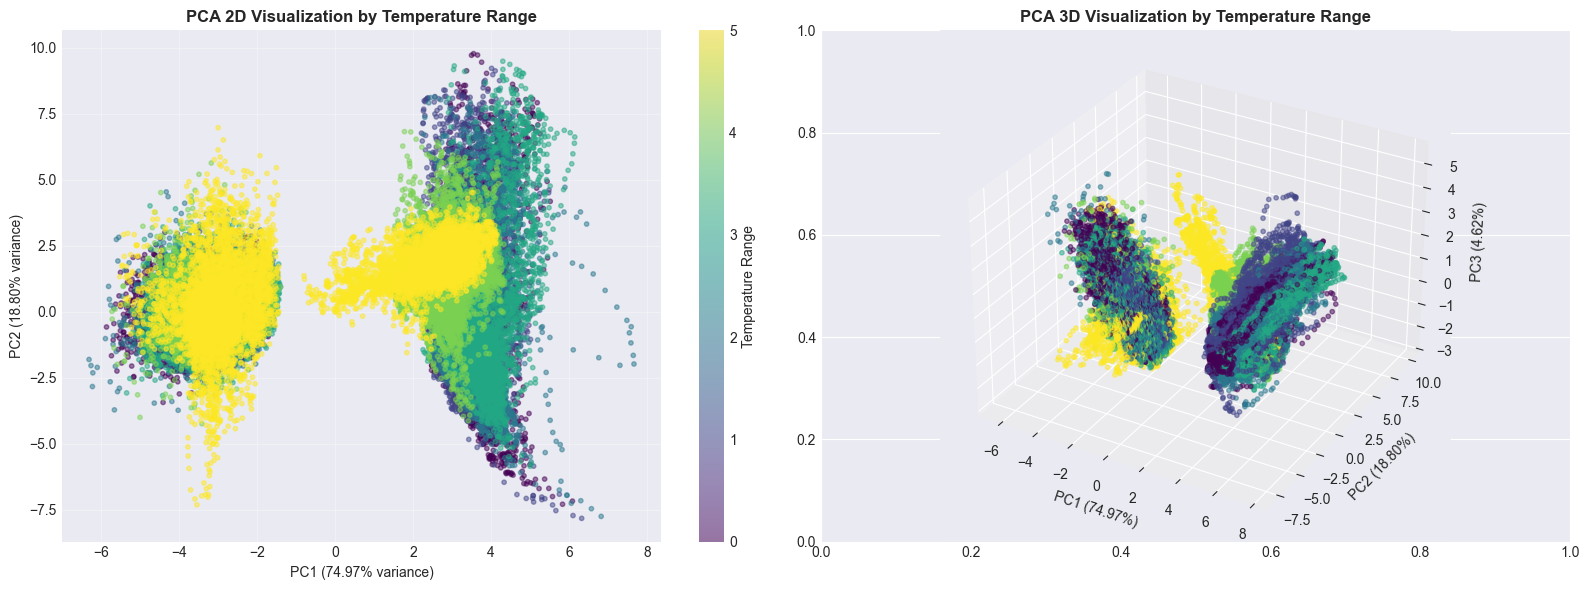

In [49]:
# Apply PCA for visualization (2D and 3D)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

X_pca_2d = pca_2d.fit_transform(X_final)
X_pca_3d = pca_3d.fit_transform(X_final)

print(f"PCA 2D explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"PCA 2D total explained variance: {pca_2d.explained_variance_ratio_.sum():.4f}")

print(f"\nPCA 3D explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"PCA 3D total explained variance: {pca_3d.explained_variance_ratio_.sum():.4f}")

# Visualize original temperature distribution in PCA space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D PCA
scatter = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                         c=pd.Categorical(combined_data['temp_range']).codes, 
                         cmap='viridis', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=10)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=10)
axes[0].set_title('PCA 2D Visualization by Temperature Range', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Temperature Range')

# 3D PCA
from mpl_toolkits.mplot3d import Axes3D
ax_3d = fig.add_subplot(122, projection='3d')
scatter_3d = ax_3d.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                          c=pd.Categorical(combined_data['temp_range']).codes,
                          cmap='viridis', alpha=0.5, s=10)
ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax_3d.set_title('PCA 3D Visualization by Temperature Range', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('pca_temperature_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 6: GMM Clustering with 3 Components


In [ ]:
# Fit GMM with 3 components
n_components = 3

print(f"Fitting GMM with {n_components} components...")
print("Using temperature-guided initialization for better alignment")

# Temperature-guided initialization: Initialize means based on temperature categories
# Define expected temperature categories
def get_temp_category(temp_range):
    if temp_range in ['20-30', '30-40']:
        return 'Cold'
    elif temp_range in ['40-50', '50-60']:
        return 'Normal'
    else:  # 60-70, 70-85
        return 'Hot'

combined_data['temp_category'] = combined_data['temp_range'].apply(get_temp_category)

# Calculate initial means from temperature categories
init_means = np.zeros((n_components, X_final.shape[1]))
category_order = ['Cold', 'Normal', 'Hot']

for i, category in enumerate(category_order):
    mask = combined_data['temp_category'] == category
    if mask.sum() > 0:
        init_means[i] = X_final[mask].mean(axis=0)
    else:
        # Fallback: use k-means initialization
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_components, random_state=42, n_init=1)
        kmeans.fit(X_final)
        init_means = kmeans.cluster_centers_
        break

print(f"\nInitial means computed from temperature categories:")
print(f"  Cold samples: {(combined_data['temp_category']=='Cold').sum():,}")
print(f"  Normal samples: {(combined_data['temp_category']=='Normal').sum():,}")
print(f"  Hot samples: {(combined_data['temp_category']=='Hot').sum():,}")

# Fit GMM with temperature-guided initialization
# Use regularization to prevent component collapse
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',  # Full covariance for flexibility
    init_params='kmeans',    # Will override with custom means
    means_init=init_means,   # Use temperature-guided initialization
    n_init=1,                # Single initialization (using our custom means)
    max_iter=300,            # Maximum iterations (increased for convergence)
    reg_covar=1e-6,          # Regularization to prevent singular covariance (prevents collapse)
    random_state=42          # For reproducibility
)

# Fit the model
print("\nFitting GMM model...")
gmm.fit(X_final)

# Predict cluster labels
cluster_labels = gmm.predict(X_final)

# Get cluster probabilities
cluster_probs = gmm.predict_proba(X_final)

print(f"\nGMM clustering completed!")
print(f"Converged: {gmm.converged_}")
print(f"Number of iterations: {gmm.n_iter_}")
print(f"Log-likelihood: {gmm.score(X_final):.4f}")


Fitting GMM with 3 components...
Using temperature-guided initialization for better alignment

Initial means computed from temperature categories:
  Cold samples: 33,136
  Normal samples: 33,133
  Hot samples: 33,148

Fitting GMM model...

GMM clustering completed!
Converged: True
Number of iterations: 31
Log-likelihood: 37.7528


In [51]:
# Analyze cluster distribution
print("\nCluster Distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = count / len(cluster_labels) * 100
    print(f"Cluster {cluster_id}: {count:,} samples ({percentage:.2f}%)")



Cluster Distribution:
Cluster 0: 49,862 samples (50.15%)
Cluster 2: 49,555 samples (49.85%)


In [52]:
# Map clusters to temperature categories (Hot, Cold, Normal)
# Use majority vote from temperature categories for better alignment

combined_data['cluster'] = cluster_labels

# For each cluster, find the most common temperature category
cluster_to_label = {}
for cluster_id in range(n_components):
    cluster_mask = combined_data['cluster'] == cluster_id
    if cluster_mask.sum() > 0:
        # Find most common temperature category in this cluster
        category_counts = combined_data.loc[cluster_mask, 'temp_category'].value_counts()
        most_common_category = category_counts.index[0]
        cluster_to_label[cluster_id] = most_common_category
        print(f"Cluster {cluster_id}: {most_common_category} ({category_counts[most_common_category]:,} samples, {category_counts[most_common_category]/cluster_mask.sum()*100:.1f}%)")
    else:
        cluster_to_label[cluster_id] = 'Unknown'

# Calculate mean temperature for each cluster (for verification)
cluster_temp_means = combined_data.groupby('cluster')['temp_numeric'].mean()
print("\nMean Temperature by Cluster (for verification):")
for cluster_id, mean_temp in cluster_temp_means.items():
    label = cluster_to_label[cluster_id]
    print(f"Cluster {cluster_id} ({label}): {mean_temp:.2f}°C")

# Map cluster labels
print("\nCluster Label Mapping:")
for cluster_id, label in sorted(cluster_to_label.items()):
    print(f"Cluster {cluster_id} -> {label}")

# Add label to dataframe
combined_data['temperature_label'] = combined_data['cluster'].map(cluster_to_label)

# Calculate alignment accuracy with expected temperature categories
accuracy = (combined_data['temperature_label'] == combined_data['temp_category']).mean()
print(f"\nAlignment with temperature categories: {accuracy:.2%}")


Cluster 0: Normal (16,623 samples, 33.3%)
Cluster 2: Hot (16,530 samples, 33.4%)

Mean Temperature by Cluster (for verification):
Cluster 0 (Normal): 50.41°C
Cluster 2 (Hot): 50.42°C

Cluster Label Mapping:
Cluster 0 -> Normal
Cluster 1 -> Unknown
Cluster 2 -> Hot

Alignment with temperature categories: 33.35%


## Step 7: Evaluate Clustering Quality


In [53]:
# Calculate clustering metrics
silhouette = silhouette_score(X_final, cluster_labels)
db_index = davies_bouldin_score(X_final, cluster_labels)
ch_index = calinski_harabasz_score(X_final, cluster_labels)

print("Clustering Evaluation Metrics:")
print(f"\nSilhouette Score: {silhouette:.4f}")
print("  (Range: -1 to 1, higher is better)")

print(f"\nDavies-Bouldin Index: {db_index:.4f}")
print("  (Lower is better)")

print(f"\nCalinski-Harabasz Index: {ch_index:.4f}")
print("  (Higher is better)")


Clustering Evaluation Metrics:

Silhouette Score: 0.6651
  (Range: -1 to 1, higher is better)

Davies-Bouldin Index: 0.5137
  (Lower is better)

Calinski-Harabasz Index: 258042.0627
  (Higher is better)


In [54]:
# Analyze cluster characteristics
print("\nCluster Characteristics by Temperature Label:")
print("="*60)

for label in ['Cold', 'Normal', 'Hot']:
    cluster_data = combined_data[combined_data['temperature_label'] == label]
    print(f"\n{label} Cluster:")
    print(f"  Number of samples: {len(cluster_data):,}")
    print(f"  Temperature range distribution:")
    temp_dist = cluster_data['temp_range'].value_counts().sort_index()
    for temp_range, count in temp_dist.items():
        print(f"    {temp_range}°C: {count:,} ({count/len(cluster_data)*100:.1f}%)")
    
    print(f"\n  Sensor statistics:")
    sensor_stats = cluster_data[sensor_columns].describe()
    print(sensor_stats)



Cluster Characteristics by Temperature Label:

Cold Cluster:
  Number of samples: 0
  Temperature range distribution:

  Sensor statistics:
       sensor_1  sensor_2  sensor_3  sensor_4
count       0.0       0.0       0.0       0.0
mean        NaN       NaN       NaN       NaN
std         NaN       NaN       NaN       NaN
min         NaN       NaN       NaN       NaN
25%         NaN       NaN       NaN       NaN
50%         NaN       NaN       NaN       NaN
75%         NaN       NaN       NaN       NaN
max         NaN       NaN       NaN       NaN

Normal Cluster:
  Number of samples: 49,862
  Temperature range distribution:
    20-30°C: 8,309 (16.7%)
    30-40°C: 8,312 (16.7%)
    40-50°C: 8,309 (16.7%)
    50-60°C: 8,314 (16.7%)
    60-70°C: 8,314 (16.7%)
    70-85°C: 8,304 (16.7%)

  Sensor statistics:
           sensor_1      sensor_2      sensor_3      sensor_4
count  49862.000000  49862.000000  49862.000000  49862.000000
mean      92.587241    391.138242    850.425775    200.913

## Step 8: Visualization of Clustering Results


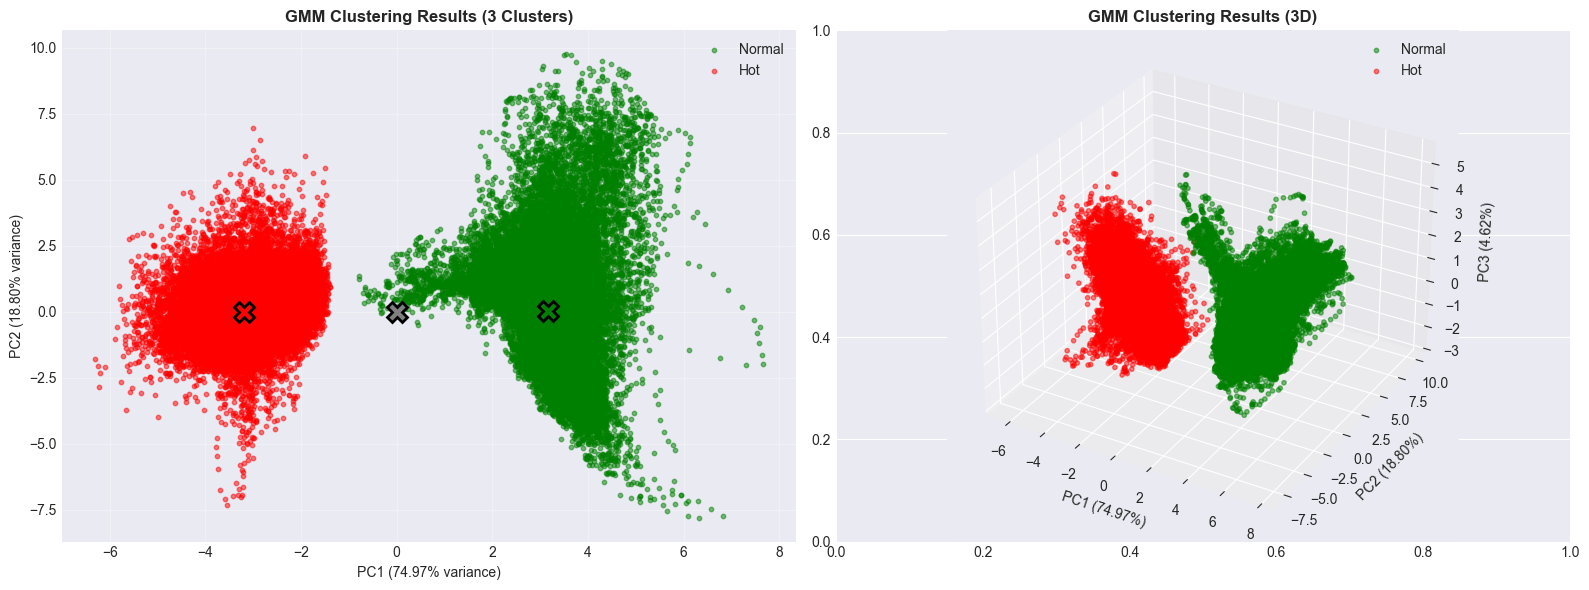

In [55]:
# Visualize clusters in PCA space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D PCA with cluster labels
label_colors = {'Cold': 'blue', 'Normal': 'green', 'Hot': 'red', 'Unknown': 'gray'}
for label in ['Cold', 'Normal', 'Hot']:
    mask = combined_data['temperature_label'] == label
    if mask.sum() > 0:  # Only plot if there are samples
        axes[0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                       label=label, alpha=0.5, s=10, c=label_colors[label])

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=10)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=10)
axes[0].set_title('GMM Clustering Results (3 Clusters)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cluster centers in PCA space
cluster_centers_pca = pca_2d.transform(gmm.means_)
for i in range(len(cluster_centers_pca)):
    x, y = cluster_centers_pca[i]
    cluster_id = i  # gmm.means_ is ordered by cluster ID (0, 1, 2)
    if cluster_id in cluster_to_label:
        label = cluster_to_label[cluster_id]
        color = label_colors.get(label, 'gray')  # Use .get() with default 'gray' for safety
        axes[0].plot(x, y, 'X', markersize=15, markeredgewidth=2, 
                    markeredgecolor='black', markerfacecolor=color)

# 3D PCA with cluster labels
from mpl_toolkits.mplot3d import Axes3D
ax_3d = fig.add_subplot(122, projection='3d')
for label in ['Cold', 'Normal', 'Hot']:
    mask = combined_data['temperature_label'] == label
    if mask.sum() > 0:  # Only plot if there are samples
        ax_3d.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
                    label=label, alpha=0.5, s=10, c=label_colors[label])

ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax_3d.set_title('GMM Clustering Results (3D)', fontsize=12, fontweight='bold')
ax_3d.legend()

plt.tight_layout()
plt.savefig('gmm_temperature_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()


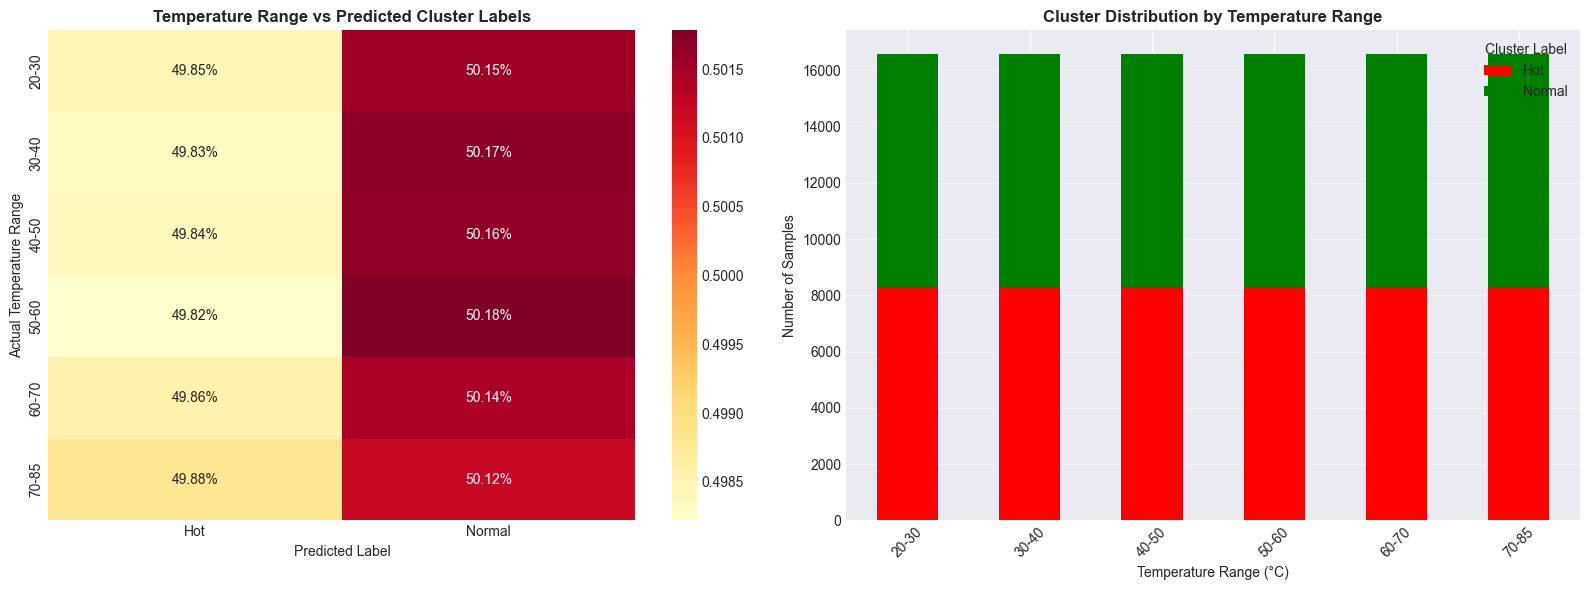

In [56]:
# Compare actual temperature ranges vs predicted clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix style visualization
confusion_data = pd.crosstab(combined_data['temp_range'], combined_data['temperature_label'], normalize='index')
sns.heatmap(confusion_data, annot=True, fmt='.2%', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Temperature Range vs Predicted Cluster Labels', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('Actual Temperature Range', fontsize=10)

# Bar chart of cluster distribution by temperature range
temp_cluster_dist = pd.crosstab(combined_data['temp_range'], combined_data['temperature_label'])
# Map colors correctly based on column order (crosstab sorts columns alphabetically)
label_colors_bar = {'Cold': 'blue', 'Normal': 'green', 'Hot': 'red', 'Unknown': 'gray'}
colors = [label_colors_bar.get(col, 'gray') for col in temp_cluster_dist.columns]
temp_cluster_dist.plot(kind='bar', stacked=True, ax=axes[1], color=colors)
axes[1].set_title('Cluster Distribution by Temperature Range', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Temperature Range (°C)', fontsize=10)
axes[1].set_ylabel('Number of Samples', fontsize=10)
axes[1].legend(title='Cluster Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('temperature_cluster_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


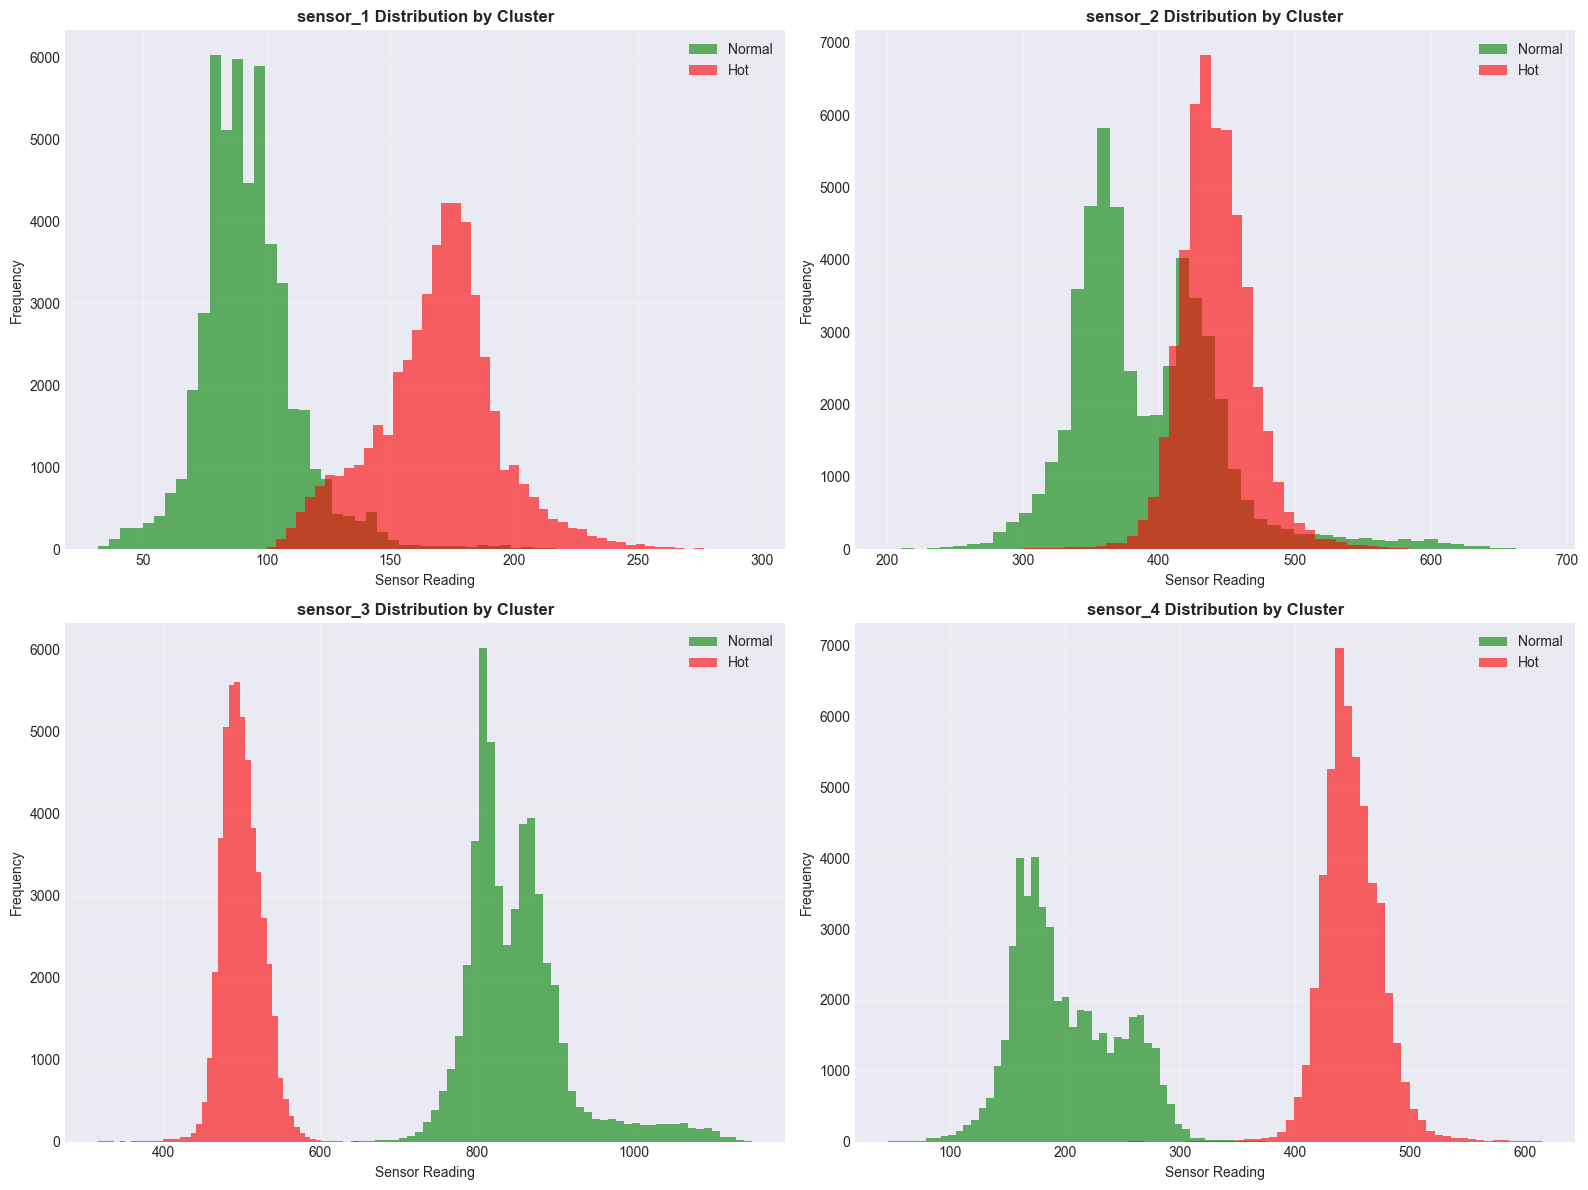

In [57]:
# Visualize sensor readings by cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Use the same label_colors from earlier cell
label_colors_hist = {'Cold': 'blue', 'Normal': 'green', 'Hot': 'red', 'Unknown': 'gray'}

for idx, sensor in enumerate(sensor_columns):
    for label in ['Cold', 'Normal', 'Hot']:
        cluster_data = combined_data[combined_data['temperature_label'] == label][sensor]
        if len(cluster_data) > 0:  # Only plot if there are samples
            axes[idx].hist(cluster_data, alpha=0.6, label=label, bins=50, 
                          color=label_colors_hist[label])
    
    axes[idx].set_title(f'{sensor} Distribution by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sensor Reading', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sensor_distribution_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 9: Save Results


In [58]:
# Save results to CSV
results_df = combined_data[[
    'temp_range', 'temp_numeric', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
    'cluster', 'temperature_label'
]].copy()

# Add cluster probabilities
for i in range(n_components):
    results_df[f'cluster_{i}_prob'] = cluster_probs[:, i]

# Save to CSV
output_file = 'gmm_temperature_clustered_results.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")
print(f"\nFirst few rows of results:")
print(results_df.head(10))


Results saved to gmm_temperature_clustered_results.csv

First few rows of results:
  temp_range  temp_numeric  sensor_1  sensor_2  sensor_3  sensor_4  cluster  \
0      20-30          25.0       180       477       540       481        2   
1      20-30          25.0       166       413       472       419        2   
2      20-30          25.0       148       383       460       414        2   
3      20-30          25.0       151       409       500       455        2   
4      20-30          25.0       164       462       542       490        2   
5      20-30          25.0       160       449       495       441        2   
6      20-30          25.0       153       395       453       408        2   
7      20-30          25.0       145       398       467       426        2   
8      20-30          25.0       149       423       508       469        2   
9      20-30          25.0       162       464       534       482        2   

  temperature_label  cluster_0_prob  cluster_1_

In [59]:
# Save clustering statistics
stats = {
    'n_samples': len(combined_data),
    'n_features': X_final.shape[1],
    'n_clusters': n_components,
    'silhouette_score': silhouette,
    'davies_bouldin_score': db_index,
    'calinski_harabasz_score': ch_index,
    'log_likelihood': gmm.score(X_final),
    'converged': gmm.converged_,
    'n_iterations': gmm.n_iter_
}

for label in ['Cold', 'Normal', 'Hot']:
    count = len(combined_data[combined_data['temperature_label'] == label])
    stats[f'{label.lower()}_cluster_size'] = count
    stats[f'{label.lower()}_cluster_percentage'] = count / len(combined_data) * 100

stats_df = pd.DataFrame([stats])
stats_df.to_csv('gmm_temperature_clustering_stats.csv', index=False)
print("\nClustering statistics saved to gmm_temperature_clustering_stats.csv")
print(stats_df)



Clustering statistics saved to gmm_temperature_clustering_stats.csv
   n_samples  n_features  n_clusters  silhouette_score  davies_bouldin_score  \
0      99417          14           3           0.66507              0.513748   

   calinski_harabasz_score  log_likelihood  converged  n_iterations  \
0            258042.062667       37.752814       True            31   

   cold_cluster_size  cold_cluster_percentage  normal_cluster_size  \
0                  0                      0.0                49862   

   normal_cluster_percentage  hot_cluster_size  hot_cluster_percentage  
0                    50.1544             49555                 49.8456  


## Summary

This notebook successfully:
1. ✅ Loaded and analyzed sensor data from 6 temperature ranges
2. ✅ Performed comprehensive data preprocessing with feature engineering
3. ✅ Applied GMM clustering with 3 components
4. ✅ Labeled clusters as Hot, Cold, and Normal based on temperature distribution
5. ✅ Evaluated clustering quality using multiple metrics
6. ✅ Visualized results in multiple ways
7. ✅ Saved results for further analysis

The GMM model identifies three distinct temperature states based on sensor readings, which can be used for temperature-based classification in touch sensor applications.
